In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install xgboost --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix,
    mean_squared_error, mean_absolute_error, r2_score,
    silhouette_score, davies_bouldin_score
)

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor

from sklearn.cluster import KMeans, DBSCAN, Birch

import xgboost as xgb


In [ ]:
path = "/content/drive/MyDrive/ml_odev/Sensorless_drive_diagnosis.txt"

df = pd.read_csv(path, sep=r"\s+", header=None)

df.shape, df.head()


((58509, 49),
              0             1         2         3             4         5   \
 0 -3.014600e-07  8.260300e-06 -0.000012 -0.000002 -1.438600e-06 -0.000021   
 1  2.913200e-06 -5.247700e-06  0.000003 -0.000006  2.778900e-06 -0.000004   
 2 -2.951700e-06 -3.184000e-06 -0.000016 -0.000001 -1.575300e-06  0.000017   
 3 -1.322600e-06  8.820100e-06 -0.000016 -0.000005 -7.282900e-07  0.000004   
 4 -6.836600e-08  5.666300e-07 -0.000026 -0.000006 -7.940600e-07  0.000013   
 
          6         7         8         9   ...       39      40      41  \
 0  0.031718  0.031710  0.031721 -0.032963  ... -0.63308  2.9646  8.1198   
 1  0.030804  0.030810  0.030806 -0.033520  ... -0.59314  7.6252  6.1690   
 2  0.032877  0.032880  0.032896 -0.029834  ... -0.63252  2.7784  5.3017   
 3  0.029410  0.029401  0.029417 -0.030156  ... -0.62289  6.5534  6.2606   
 4  0.030119  0.030119  0.030145 -0.031393  ... -0.63010  4.5155  9.5231   
 
        42      43      44      45      46      47  48  
 

In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58509 entries, 0 to 58508
Data columns (total 49 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       58509 non-null  float64
 1   1       58509 non-null  float64
 2   2       58509 non-null  float64
 3   3       58509 non-null  float64
 4   4       58509 non-null  float64
 5   5       58509 non-null  float64
 6   6       58509 non-null  float64
 7   7       58509 non-null  float64
 8   8       58509 non-null  float64
 9   9       58509 non-null  float64
 10  10      58509 non-null  float64
 11  11      58509 non-null  float64
 12  12      58509 non-null  float64
 13  13      58509 non-null  float64
 14  14      58509 non-null  float64
 15  15      58509 non-null  float64
 16  16      58509 non-null  float64
 17  17      58509 non-null  float64
 18  18      58509 non-null  float64
 19  19      58509 non-null  float64
 20  20      58509 non-null  float64
 21  21      58509 non-null  float64
 22

In [ ]:
df.isna().sum().head()


,0
0,0
1,0
2,0
3,0
4,0


In [ ]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

X.shape, y.shape


((58509, 48), (58509,))

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

X_train.shape, X_test.shape


((46807, 48), (11702, 48))

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

log_reg = LogisticRegression(
    max_iter=2000,
    n_jobs=-1,
    multi_class="multinomial",
    solver="saga"
)

log_reg.fit(X_train_scaled, y_train)
y_pred_lr = log_reg.predict(X_test_scaled)
y_pred_lr_proba = log_reg.predict_proba(X_test_scaled)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Precision (weighted):", precision_score(y_test, y_pred_lr, average='weighted'))
print("Recall (weighted):", recall_score(y_test, y_pred_lr, average='weighted'))
print("F1-score (weighted):", f1_score(y_test, y_pred_lr, average='weighted'))

print("ROC-AUC (macro):", roc_auc_score(y_test, y_pred_lr_proba, multi_class='ovo'))


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression Accuracy: 0.9065971628781405
Precision (weighted): 0.9062413986178144
Recall (weighted): 0.9065971628781405
F1-score (weighted): 0.9062110320574167
ROC-AUC (macro): 0.9941930981198651


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_pred_rf_proba = rf.predict_proba(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision (weighted):", precision_score(y_test, y_pred_rf, average='weighted'))
print("Recall (weighted):", recall_score(y_test, y_pred_rf, average='weighted'))
print("F1-score (weighted):", f1_score(y_test, y_pred_rf, average='weighted'))
print("ROC-AUC (macro):", roc_auc_score(y_test, y_pred_rf_proba, multi_class='ovo'))


Random Forest Accuracy: 0.9990599897453427
Precision (weighted): 0.9990607104708815
Recall (weighted): 0.9990599897453427
F1-score (weighted): 0.9990597076027066
ROC-AUC (macro): 0.9999986459741953


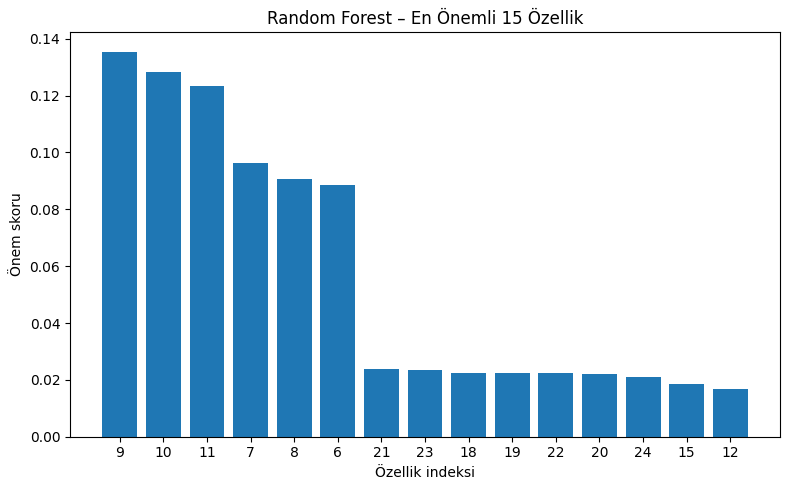

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Random Forest önem skorları
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1][:15]

plt.figure(figsize=(8,5))
plt.bar(range(len(indices)), importances[indices])
plt.xticks(range(len(indices)), indices)
plt.xlabel("Özellik indeksi")
plt.ylabel("Önem skoru")
plt.title("Random Forest – En Önemli 15 Özellik")
plt.tight_layout()

plt.savefig("rf_feature_importance.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
import numpy as np

y_train_xgb = y_train - 1
y_test_xgb = y_test - 1

np.unique(y_train), np.unique(y_train_xgb)


(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]))

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

num_classes = len(np.unique(y_train_xgb))

xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multi:softprob",
    num_class=num_classes,
    n_jobs=-1
)

xgb_model.fit(X_train_scaled, y_train_xgb)
y_pred_xgb = xgb_model.predict(X_test_scaled)
y_pred_xgb_proba = xgb_model.predict_proba(X_test_scaled)

print("XGBoost Accuracy:", accuracy_score(y_test_xgb, y_pred_xgb))
print("Precision (weighted):", precision_score(y_test_xgb, y_pred_xgb, average='weighted'))
print("Recall (weighted):", recall_score(y_test_xgb, y_pred_xgb, average='weighted'))
print("F1-score (weighted):", f1_score(y_test_xgb, y_pred_xgb, average='weighted'))
print("ROC-AUC (macro):", roc_auc_score(y_test_xgb, y_pred_xgb_proba, multi_class='ovo'))


XGBoost Accuracy: 0.9989745342676466
Precision (weighted): 0.9989758147868752
Recall (weighted): 0.9989745342676466
F1-score (weighted): 0.9989742918673438
ROC-AUC (macro): 0.999999236810206


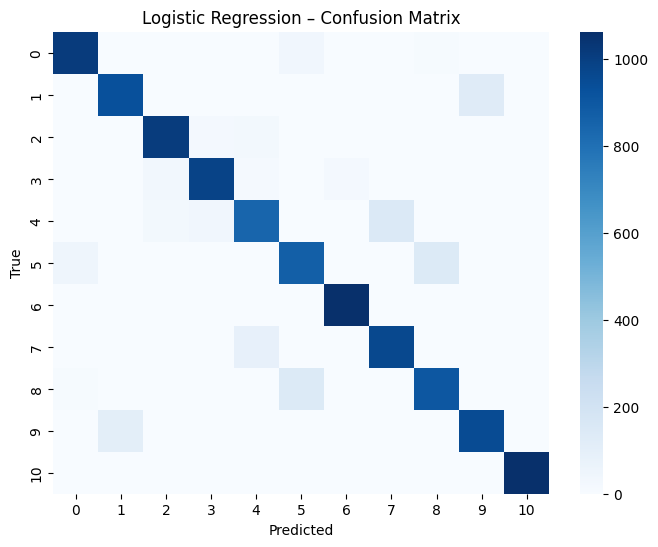

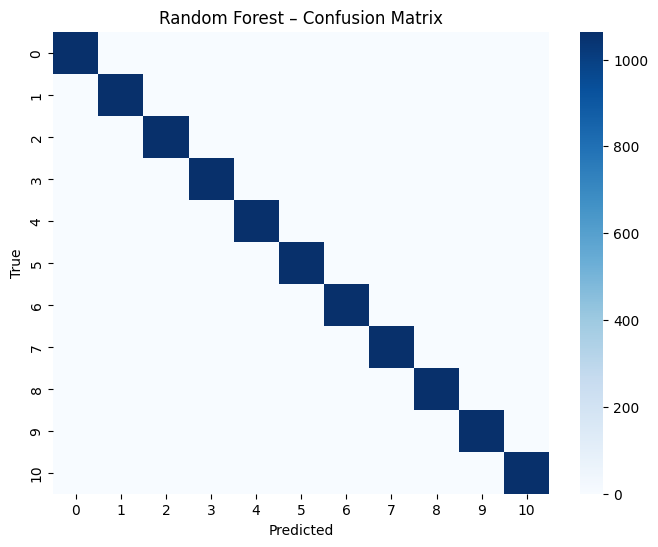

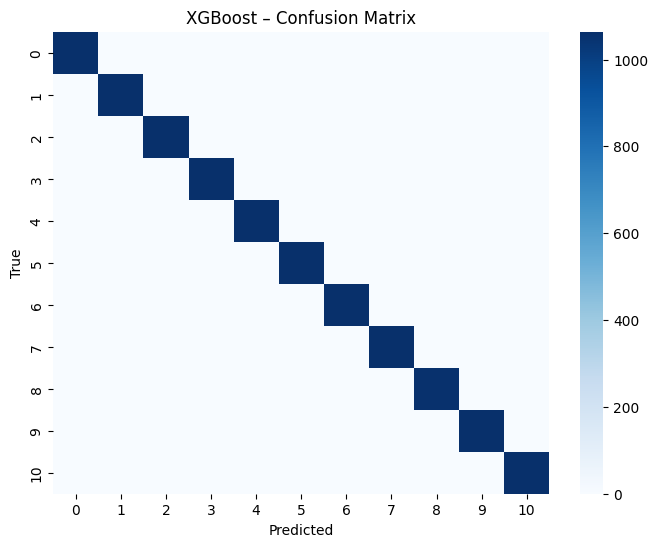

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

models = {
    "Logistic Regression": y_pred_lr,
    "Random Forest": y_pred_rf,
    "XGBoost": y_pred_xgb
}

true_labels = {
    "Logistic Regression": y_test,
    "Random Forest": y_test,
    "XGBoost": y_test_xgb
}

for model_name in models:
    plt.figure(figsize=(8,6))
    cm = confusion_matrix(true_labels[model_name], models[model_name])
    sns.heatmap(cm, annot=False, cmap="Blues")
    plt.title(f"{model_name} – Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


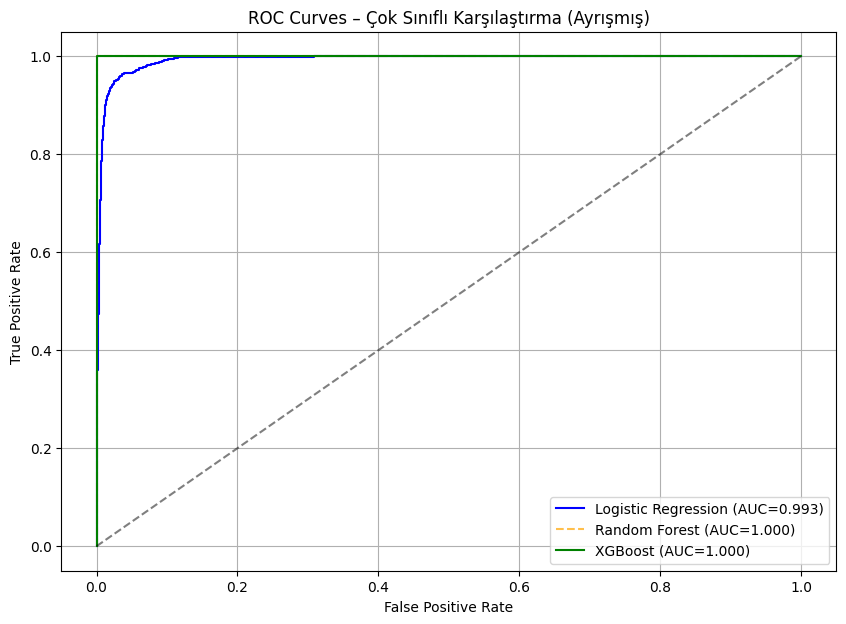

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

plt.figure(figsize=(10, 7))

def plot_model_roc(y_test_bin, proba, label, color, style="-", alpha=1.0):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(y_test_bin.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[1], tpr[1], style, color=color, alpha=alpha,
             label=f"{label} (AUC={roc_auc[1]:.3f})")

# Logistic Regression
plot_model_roc(y_test_bin, y_pred_lr_proba,
               "Logistic Regression", color="blue", style="-", alpha=1.0)

# Random Forest
plot_model_roc(y_test_bin, y_pred_rf_proba,
               "Random Forest", color="orange", style="--", alpha=0.7)

# XGBoost
plot_model_roc(y_test_bin, y_pred_xgb_proba,
               "XGBoost", color="green", style="-", alpha=1.0)

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves – Çok Sınıflı Karşılaştırma (Ayrışmış)")
plt.legend()
plt.grid(True)

plt.savefig("roc_curve_multi_fixed.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
import pandas as pd

results = {
    "Model": ["Logistic Regression", "Random Forest", "XGBoost"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test_xgb, y_pred_xgb)
    ],
    "Precision (weighted)": [
        precision_score(y_test, y_pred_lr, average='weighted'),
        precision_score(y_test, y_pred_rf, average='weighted'),
        precision_score(y_test_xgb, y_pred_xgb, average='weighted')
    ],
    "Recall (weighted)": [
        recall_score(y_test, y_pred_lr, average='weighted'),
        recall_score(y_test, y_pred_rf, average='weighted'),
        recall_score(y_test_xgb, y_pred_xgb, average='weighted')
    ],
    "F1-score (weighted)": [
        f1_score(y_test, y_pred_lr, average='weighted'),
        f1_score(y_test, y_pred_rf, average='weighted'),
        f1_score(y_test_xgb, y_pred_xgb, average='weighted')
    ],
    "ROC-AUC (macro)": [
        roc_auc_score(y_test, y_pred_lr_proba, multi_class='ovo'),
        roc_auc_score(y_test, y_pred_rf_proba, multi_class='ovo'),
        roc_auc_score(y_test_xgb, y_pred_xgb_proba, multi_class='ovo')
    ]
}

df_results = pd.DataFrame(results)
df_results


,Model,Accuracy,Precision (weighted),Recall (weighted),F1-score (weighted),ROC-AUC (macro)
0,Logistic Regression,0.906597,0.906241,0.906597,0.906211,0.994193
1,Random Forest,0.999060,0.999061,0.999060,0.999060,0.999999
2,XGBoost,0.998975,0.998976,0.998975,0.998974,0.999999


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

rf_gs = RandomForestClassifier(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(
    estimator=rf_gs,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("En iyi parametreler:", grid_search.best_params_)
print("En yüksek doğruluk:", grid_search.best_score_)


Fitting 3 folds for each of 48 candidates, totalling 144 fits


KeyboardInterrupt: 

In [ ]:
import time
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

y_train_adj = y_train - y_train.min()
y_test_adj = y_test - y_test.min()


start_lr = time.time()
lr_temp = LogisticRegression(max_iter=300, solver="lbfgs")
lr_temp.fit(X_train_scaled, y_train_adj)
end_lr = time.time()
lr_time = end_lr - start_lr
print("Logistic Regression Eğitim Süresi: {:.2f} saniye".format(lr_time))


start_rf = time.time()
rf_temp = RandomForestClassifier(n_estimators=100, max_depth=None)
rf_temp.fit(X_train, y_train_adj)
end_rf = time.time()
rf_time = end_rf - start_rf
print("Random Forest Eğitim Süresi: {:.2f} saniye".format(rf_time))


start_xgb = time.time()
xgb_temp = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    objective="multi:softprob",
    num_class=len(np.unique(y_train_adj)),
    eval_metric="mlogloss"
)
xgb_temp.fit(X_train_scaled, y_train_adj)
end_xgb = time.time()
xgb_time = end_xgb - start_xgb
print("XGBoost Eğitim Süresi: {:.2f} saniye".format(xgb_time))



start_gs = time.time()
grid_search.fit(X_train, y_train_adj)
end_gs = time.time()
gs_time = end_gs - start_gs
print("GridSearchCV Toplam Süresi: {:.2f} saniye".format(gs_time))
